In [58]:
import os
import json
from typing import Dict, List
from itertools import permutations
import requests
import requests_cache
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Configure EODHD API token from environment variable
api_token = os.environ.get('EODHD_API_TOKEN')

# Cache HTTP requests to avoid hitting rate limits and speed up reruns
requests_cache.install_cache('cache')  # creates/uses cache.sqlite in project root

currencies_universe = ['USD','EUR','GBP']
window = 5

In [59]:
CUR = 'EUR.FOREX'
url = f'https://eodhd.com/api/exchange-symbol-list/FOREX'
query = {'api_token': api_token, "fmt": "json"}
data = requests.get(url, params=query)
if data.status_code != 200:
    print(f"Error: {data.status_code}")
    print(data.text)

data = data.json()
df = pd.DataFrame(data)

pairs = []

existing_codes = set(df['Code'].dropna().astype(str))
new_pairs = []
missing = []

for base, quote in permutations(currencies_universe, 2):
    code = f'{base}{quote}'
    if code in existing_codes:
        new_pairs.append(code)
    else:
        missing.append(code)

pairs = list(dict.fromkeys(pairs + new_pairs))

In [60]:
def fetch_eod_pair(pair: str) -> pd.Series:
    symbol = f"{pair}.FOREX"
    url = f"https://eodhd.com/api/eod/{symbol}"
    params = {
        'api_token': api_token,
        'fmt': 'json',
        'from': '2003-01-01',
        'order': 'a'  # ascending by date
    }
    data = requests.get(url, params=params).json()
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')
    s = df['close'].astype(float)
    s.name = pair
    return s

all_series: List[pd.Series] = []
for i, pair in enumerate(pairs, start=1):
    s = fetch_eod_pair(pair)
    if not s.empty:
        all_series.append(s)
    else:
        print(f"Skipping {pair} (no data)")

rates_df = pd.concat(all_series, axis=1, join='outer').sort_index()

rates_df = rates_df.ffill()
rates_df

,USDEUR,USDGBP,EURUSD,EURGBP,GBPUSD,GBPEUR
date,,,,,,
2003-01-01,NaN,NaN,1.0360,NaN,1.6101,NaN
2003-01-02,0.9651,0.6273,1.0410,0.6500,1.5939,1.5385
2003-01-03,0.9595,0.6214,1.0410,0.6476,1.6091,1.5442
2003-01-04,0.9595,0.6214,1.0417,0.6476,1.6091,1.5442
2003-01-05,0.9595,0.6214,1.0467,0.6476,1.6091,1.5442
...,...,...,...,...,...,...
2025-09-29,0.8541,0.7448,1.1698,0.8726,1.3405,1.1450
2025-09-30,0.8524,0.7437,1.1698,0.8726,1.3405,1.1459
2025-10-01,0.8521,0.7420,1.1698,0.8726,1.3405,1.1490


In [61]:
eur = 'EUR'
new_built = []

def get_rate(col_name: str):
    # Returns series for a pair if present, else None
    return rates_df[col_name] if col_name in rates_df.columns else None

print("Building missing pairs via EUR cross where possible...")
for code in list(missing):
    base, quote = code[:3], code[3:]

    # Skip if already created earlier in notebook
    if code in rates_df.columns:
        continue

    # If reverse exists, use inversion (already handled earlier but keep safe)
    reverse_code = f"{quote}{base}"
    if reverse_code in rates_df.columns:
        rates_df[code] = 1.0 / rates_df[reverse_code]
        new_built.append(code)
        continue

    base_eur = None
    be = f"{base}{eur}"
    eb = f"{eur}{base}"
    s_be = get_rate(be)
    s_eb = get_rate(eb)
    if s_be is not None:
        base_eur = s_be
    elif s_eb is not None:
        base_eur = 1.0 / s_eb

    # Options to derive quote/EUR:
    #   quote_eur = QUOTEEUR or 1 / EURQUOTE
    quote_eur = None
    qe = f"{quote}{eur}"
    eq = f"{eur}{quote}"
    s_qe = get_rate(qe)
    s_eq = get_rate(eq)
    if s_qe is not None:
        quote_eur = s_qe
    elif s_eq is not None:
        quote_eur = 1.0 / s_eq

    # If both found, AB = (base/EUR) / (quote/EUR)
    if base_eur is not None and quote_eur is not None:
        synth = (base_eur / quote_eur).rename(code)
        # Align index and add to dataframe
        rates_df[code] = synth
        new_built.append(code)
    else:
        # Inform which leg is missing
        need = []
        if base_eur is None:
            need.append(f"{base} via EUR")
        if quote_eur is None:
            need.append(f"{quote} via EUR")
        print(f"Skipping {code} (missing {' & '.join(need)})")

print(f"Synthesized {len(new_built)} pairs via EUR:", new_built)

# Forward fill any gaps introduced
rates_df = rates_df.sort_index().ffill()

# add missing to pairs list
pairs = list(dict.fromkeys(pairs + new_built))

Building missing pairs via EUR cross where possible...
Synthesized 0 pairs via EUR: []


In [62]:
with open('currencies_weights.json') as f:
    weights = json.load(f)

def calc_cur_index(cur, rates_df, weights):
    mydict = {}
    # filter the pairs that contain the currency and revert the rate if needed
    for pair in rates_df.columns:
        if cur == pair[3:]:
            mydict[pair[:3]] = rates_df[pair]
        elif cur == pair[:3]:
            mydict[pair[3:]] = 1 / rates_df[pair]
        else:
            pass

    df_currency = pd.DataFrame(mydict)

    weighted_weights = []
    for col in df_currency.columns:
        weighted_weights.append(weights[col]['GDP'])

    weighted_weights = [weight / sum(weighted_weights) for weight in weighted_weights]

    df_index_prep = df_currency.copy()
    df_index_prep = df_index_prep.pct_change(fill_method=None)
    weights_df = pd.DataFrame(weighted_weights, index=df_index_prep.columns, columns=['Weight'])
    df_index = df_index_prep.dot(weights_df['Weight']).cumsum(axis=0)*1000

    return df_index

backtest_df = rates_df.copy()
for cur in currencies_universe:
    backtest_df[cur] = calc_cur_index(cur, rates_df,  weights)

# Fill NaN values forward with the previous available value
backtest_df = backtest_df.ffill()

In [63]:
for pair in pairs:
    if pair in rates_df.columns:
        backtest_df[f"{pair}_pct_change"] = backtest_df[pair].pct_change(fill_method=None)

In [64]:
for cur in currencies_universe:
    col = cur
    if col in backtest_df.columns:
        backtest_df[f"{cur}_MA"] = backtest_df[col].rolling(window=window, min_periods=1).mean()
    else:
        print(f"Skipping {col} (not found in dataset)")
    # calculate the percentage of the currency against the index
    backtest_df[f"{col}_MA_diff_index"] = (backtest_df[col] - backtest_df[f"{cur}_MA"]) / backtest_df[f"{cur}_MA"]

backtest_df = backtest_df.iloc[window:]

In [65]:
ma_diff_cols = [f"{cur}_MA_diff_index" for cur in currencies_universe if f"{cur}_MA_diff_index" in backtest_df.columns]

highest_series = backtest_df[ma_diff_cols].idxmax(axis=1).str.replace("_MA_diff_index", "", regex=False)
lowest_series = backtest_df[ma_diff_cols].idxmin(axis=1).str.replace("_MA_diff_index", "", regex=False)

backtest_df["highest_MA_diff_currency"] = highest_series
backtest_df["lowest_MA_diff_currency"] = lowest_series

In [66]:
backtest_df['trading_pair'] = backtest_df["highest_MA_diff_currency"] + backtest_df["lowest_MA_diff_currency"]
# shift one the trading pair
backtest_df['trading_pair'] = backtest_df['trading_pair'].shift(1)

In [67]:
def get_strategy_return(row):
    if row['trading_pair'] == None:
        return None
    return row[f"{row['trading_pair']}_pct_change"]

backtest_df['strategy_return'] = backtest_df.apply(get_strategy_return, axis=1)

equity = (1 + backtest_df['strategy_return'].fillna(0)).cumprod()
final_equity = equity.iloc[-1]
print(final_equity)

13.738699494026134


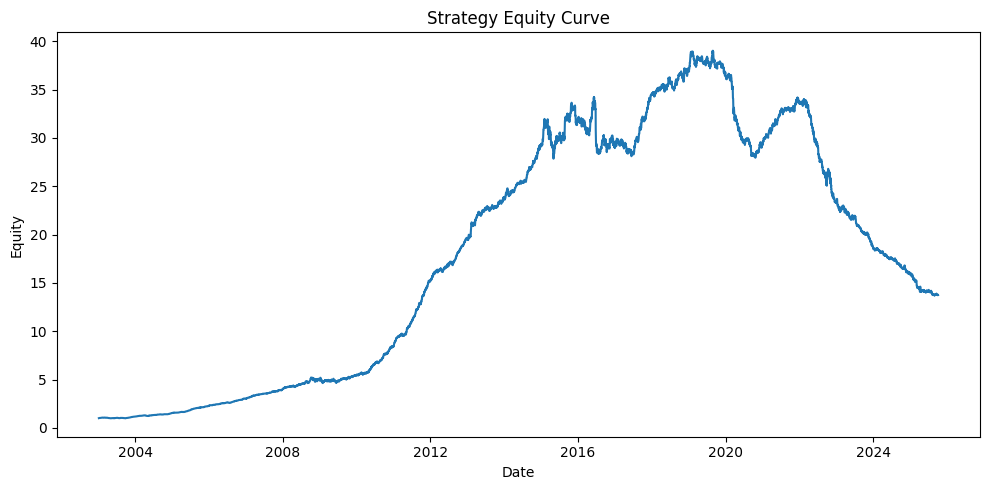

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(equity.index, equity.values)
plt.title('Strategy Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.tight_layout()
plt.show()